In [1]:
# coding: utf8
import os
import itertools

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import scipy
from scipy import linalg
from scipy.io import loadmat
from sklearn import mixture

from gmm_lbd.gmm import LbdGMM
from gmm_lbd.data_manager import GmmManager, plot_2D_mean_covars
from gmm_lbd.operations import conc, seq

%matplotlib inline



In [2]:
# datas taken from calinon matlab code GMM-GMR-v2 
data1 = loadmat('records/data1.mat')['Data'].transpose()
data2_a = loadmat('records/data2_a.mat')['Data'].transpose()
data2_b = loadmat('records/data2_b.mat')['queryData'].transpose()
data3_a = loadmat('records/data3_a.mat')['Data1'].transpose()
data3_b = loadmat('records/data3_b.mat')['Data2'].transpose()


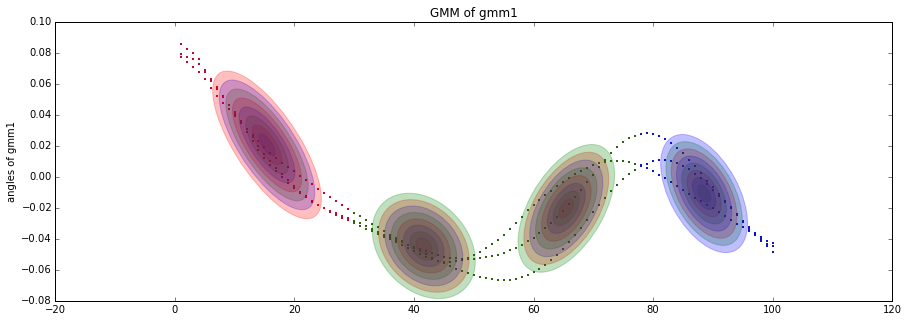

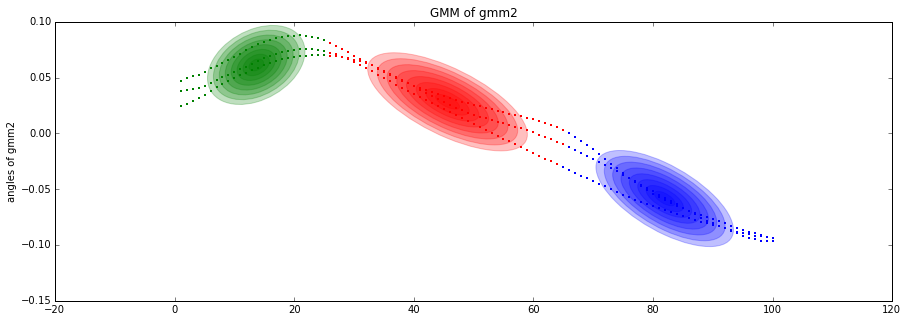

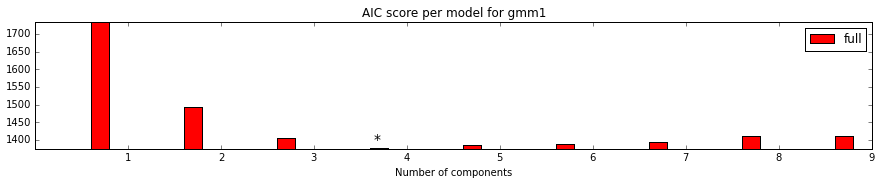

In [3]:
manager = GmmManager(n_components_range=range(1,10))
x = np.linspace(min(data1[:,0]), max(data1[:,0]), 500)

manager.add_dataset(data1[:,[0,1]],name='gmm1')
#manager.add_dataset(data1,name='data11')

manager.add_dataset(data1[:,[0,2]],name='gmm2')

ax =manager.plot_ellipses_and_samples('gmm1')
#manager.plot_regression('data11', ax)


ax2 = manager.plot_ellipses_and_samples('gmm2')
#manager.plot_regression('data12')

manager.plot_bics('gmm1')


## Combinaison (product) of constraints for the two above movements
The combinaison is made with the product of the retrived movements (made with the regression of the GMMs)

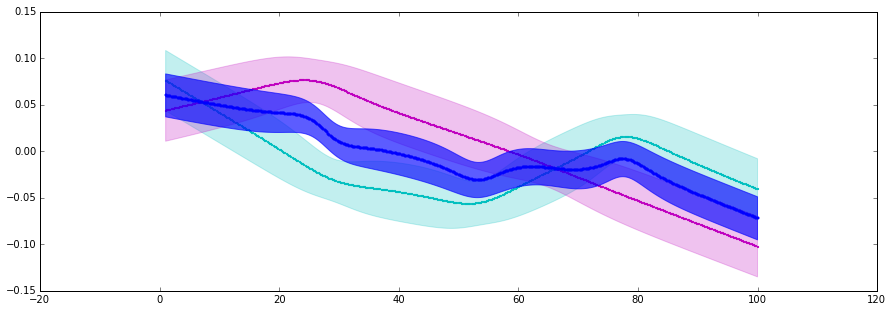

In [4]:
X = manager.datasets['gmm1']
gmm1, gmm2 = manager.gmms['gmm1'], manager.gmms['gmm2']
x = np.linspace(min(X[:,0]), max(X[:,0]), 500)

plt.figure(figsize=(15, 5))
ax = plt.subplot(111)
#manager.plot_ellipses_and_samples('data11', ax=ax)
#manager.plot_ellipses_and_samples('data12', ax=ax)

plot_2D_mean_covars(gmm1.regression(x), ax=ax, color='c', size= 0.3)
plot_2D_mean_covars(gmm2.regression(x), ax=ax, color='m', size= 0.3)
plot_2D_mean_covars(conc(x, gmm1, gmm2), ax=ax, size=0.8)


### We can also concatenate the GMM and made the regression

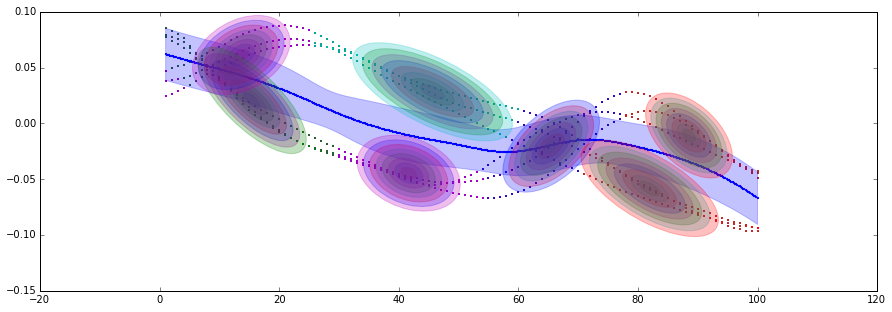

In [5]:
gmm4 = seq(gmm1 ,gmm2, ver='align')
x = np.linspace(min(gmm4.X_[:,0]), max(gmm4.X_[:,0]), 500)

ax = gmm4.plot_ellipses()

plot_2D_mean_covars(gmm4.regression(x), ax=ax)

## Sequence (concatenation) of the two movments

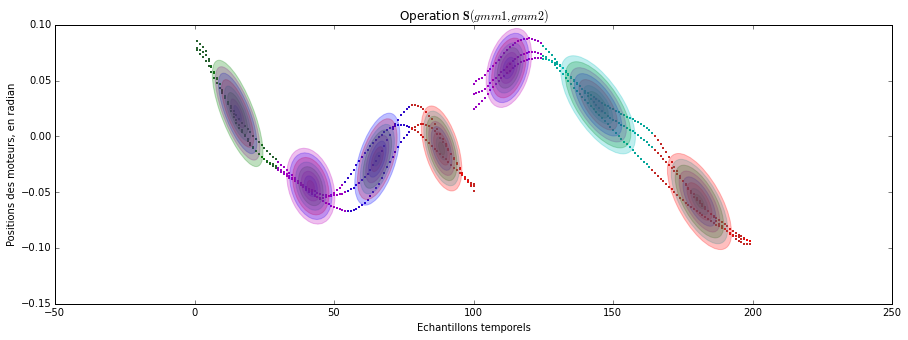

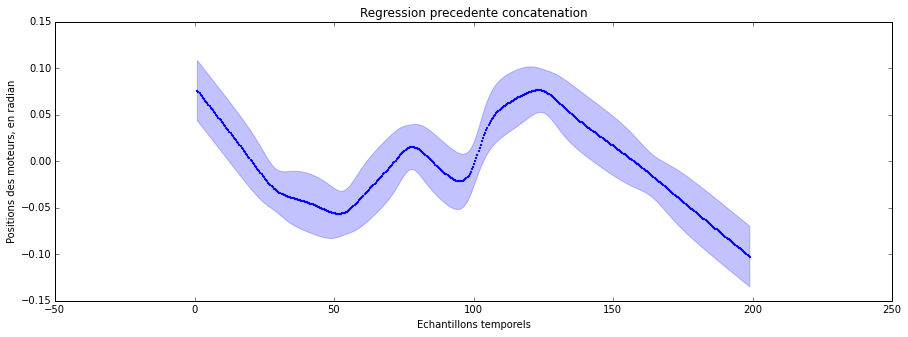

In [12]:

gmm3 = seq(gmm1,gmm2)

ax = gmm3.plot_ellipses()
ax.set_title('Operation $\mathbf{S}(gmm1,gmm2)$')
ax.set_ylabel('Positions des moteurs, en radian')
ax.set_xlabel('Echantillons temporels')


ax2 = plot_2D_mean_covars(gmm3.regression())
ax2.set_title('Regression precedente concatenation')
ax2.set_ylabel('Positions des moteurs, en radian')
ax2.set_xlabel('Echantillons temporels')


### Other datas...

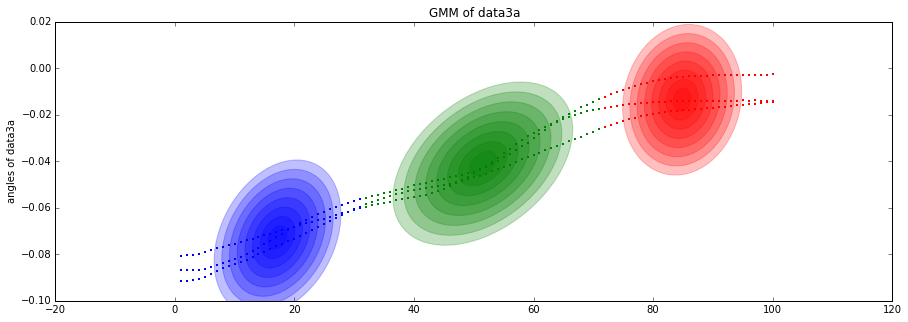

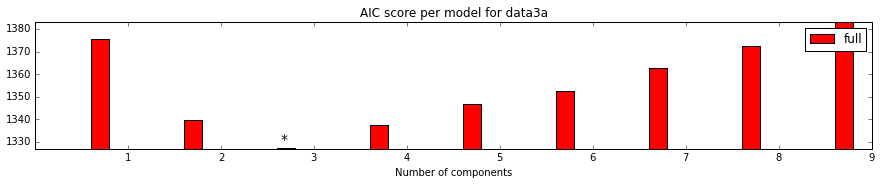

In [7]:
manager.add_dataset(data3_a[:,[0,1]],name='data3a')
manager.add_dataset(data3_b[:,[0,1]],name='data3b')
manager.plot_ellipses_and_samples('data3a')
manager.plot_bics('data3a')



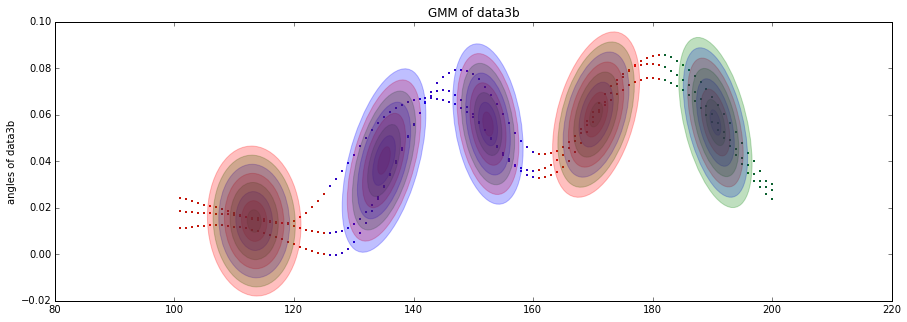

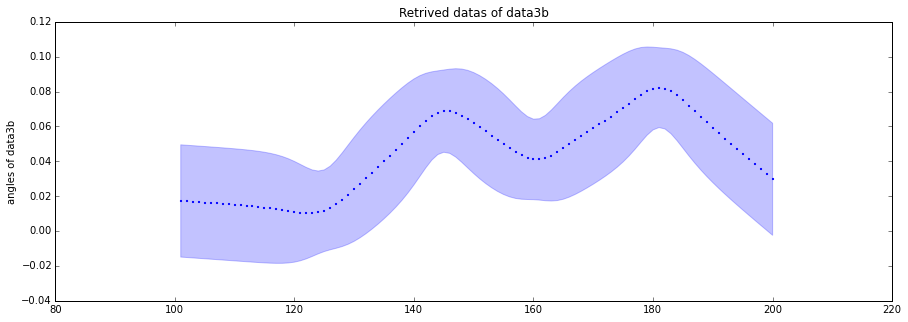

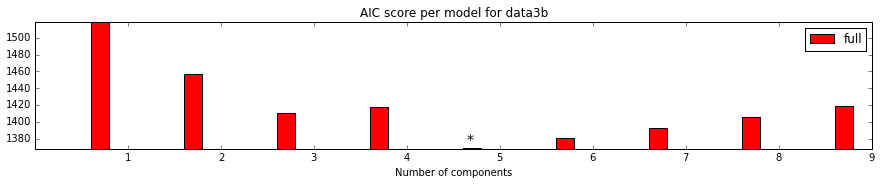

In [8]:
manager.plot_ellipses_and_samples('data3b')
manager.plot_regression('data3b')
manager.plot_bics('data3b')



In [15]:
gmm1.covars_

array([[[  7.43225539e+01,  -8.48491627e-02],
        [ -8.48491627e-02,   1.15584718e-03]],

       [[  5.27429488e+01,  -1.38776694e-01],
        [ -1.38776694e-01,   1.45197484e-03]],

       [[  8.26789568e+01,  -3.17476247e-01],
        [ -3.17476247e-01,   2.26962903e-03]],

       [[  6.52563006e+01,   1.75828450e-01],
        [  1.75828450e-01,   1.69830377e-03]]])

In [27]:
x, means, cov = gmm1.regression()
cov = cov[:,0]

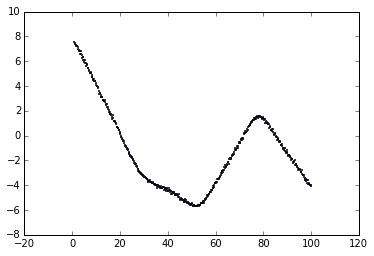

In [40]:
s =np.empty(means.shape)
for i in range(cov.shape[0]):
    s[i] = 100 * np.random.normal(means[i],cov[i])
plt.scatter(x,s, 0.8)

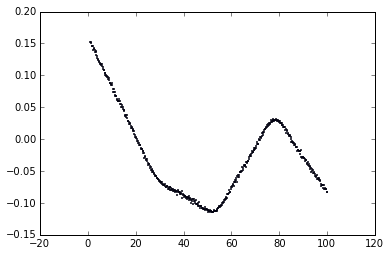